In [145]:
import tensorflow as tf
from matplotlib import pyplot as plt

def f(x):
    return tf.sin(x) * 8 + .5

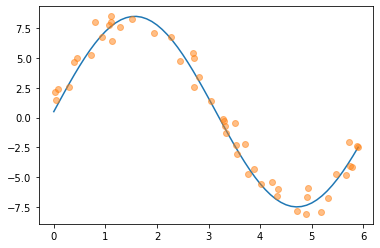

In [146]:
# 先构建一些测试数据
tf.random.set_seed(32)
# 训练集
n_train = 50
x = tf.random.uniform((n_train, ), maxval=6)
y = f(x) + tf.random.normal((n_train, ), mean=0, stddev=1)
# 测试集
x_test = tf.range(0, 6, .1)
y_test = f(x_test)
n_test = len(x_test)

def _plot(y_test_pred=None):
    # 测试集
    plt.plot(x_test, y_test)
    # 测试集上的预测值
    if y_test_pred is not None:
        plt.plot(x_test, y_test_pred)
    # 训练集
    plt.plot(x, y, 'o', alpha=.5)
_plot()

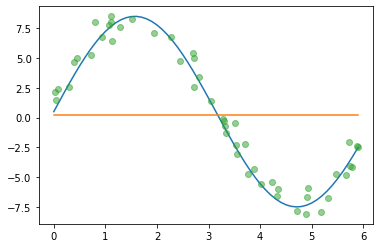

In [147]:
# 先使用avgpool模拟attentionpool
# 每一个预测值直接从y生成，此时的attentionpool就相当于没有注意力，并且忽略了x
y_hat = tf.repeat(tf.reduce_mean(y), repeats=n_test)
_plot(y_hat)

In [148]:
def softmax(logits):
    exp = tf.exp(logits)
    return exp / tf.reduce_sum(exp, axis=1, keepdims=True)

def gaussian_reg(quires, key, value):
    # quires.shape=(50,) key.shape(50,) value.shape(50,)
    # output.shape=(50,)
    pass

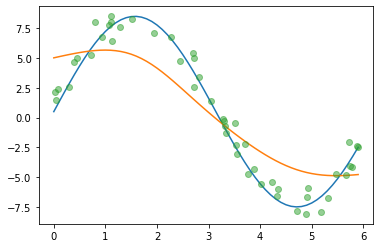

In [149]:
# 把x按照测试集的长度扩展一遍，x_repeated.shape=(n_test, *x.shape)
x_repeated = tf.repeat(tf.expand_dims(x, axis=0), repeats=n_test, axis=0)

# attention_weights.shape=(n_test, *x.shape) 表示测试集每个x在训练集上的attention权重系数
attention_weights = softmax(-((tf.expand_dims(x_test, axis=1) - x_repeated) ** 2 / 2))
# y.shape=(50,)  attention_weights.shape=(60,50)  输出y_test_pred.shape=(60,)
y_test_pred = tf.matmul(attention_weights, tf.expand_dims(y, axis=1))
_plot(y_test_pred)

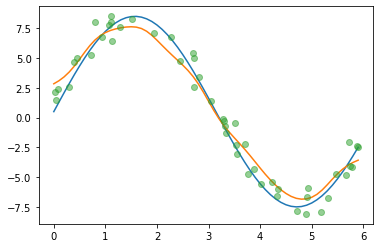

In [150]:
# 增加一个权重参数进行训练？
w = tf.Variable(initial_value=tf.random.uniform(shape=(1,)), trainable=True)
epochs = 100
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
for epoch in range(epochs):
    x_repeated = tf.repeat(tf.expand_dims(x, axis=0), repeats=n_train, axis=0)
    with tf.GradientTape() as gt:
        # 增加一个训练参数w
        attention_weights = softmax(-(((tf.expand_dims(x, axis=1) - x_repeated) * w) ** 2 / 2))
        # y.shape=(50,)  attention_weights.shape=(60,50)  输出y_test_pred.shape=(60,)
        y_pred = tf.matmul(attention_weights, tf.expand_dims(y, axis=1))
        loss = loss_fn(y, y_pred)
    grad = gt.gradient(loss, w)
    optimizer.apply_gradients(zip((grad,), (w, )))
    
x_repeated = tf.repeat(tf.expand_dims(x, axis=0), repeats=n_test, axis=0)

attention_weights = softmax(-(((tf.expand_dims(x_test, axis=1) - x_repeated) * w) ** 2 / 2))

y_test_pred = tf.matmul(attention_weights, tf.expand_dims(y, axis=1))
_plot(y_test_pred)